In [1]:
import importlib
from ipykernel import get_connection_file
from IPython.display import clear_output
import json
import logging
import numpy as np
from matplotlib import pyplot as plt
import os
import pandas as pd
import torch
import torch.nn as nn
import scipy.io
import seaborn as sns
import sklearn.metrics
from sklearn.manifold import TSNE
import sys

from base_functions import get_local_folder

current = get_local_folder()
parent = os.path.dirname(current)
sys.path.append(parent)
sys.path.append(os.path.join(parent, "models"))

from data.dataset import EyeDataset

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [3]:
model_architecture = "protoeyetcn"
# "eyecnn", "eyetcn", "protoeyetcn"

# Load modules and params
module = importlib.import_module(f'models.model.{model_architecture}')
Model = module.Model
params = importlib.import_module(f'models.model.params.{model_architecture}_params')

model_params = params.model_params
data_params = params.data_params
log_params = params.log_params
train_params = params.train_params

In [4]:
log_fmt = '%(asctime)s - %(name)s - %(levelname)s - %(message)s'
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG, format=log_fmt)

logger = logging.getLogger(__name__)
logger.info(f'Evaluating model {model_architecture}')

2025-01-31 10:47:36,391 - __main__ - INFO - Evaluating model protoeyetcn


In [5]:
# Create loss function
if model_params.criterion == 'BCE':
    criterion = nn.BCELoss()
elif model_params.criterion == 'BCE_with_logits':
    criterion = nn.BCEWithLogitsLoss()
elif model_params.criterion == 'CE':
    criterion = nn.CrossEntropyLoss()
else:
    logger.info(f"ERROR: Unsupported loss function: {model_params.criterion}")
    sys.exit()

regularizer = None

In [6]:
# Instantiate and initiate the model
if 'proto' in model_architecture:
    stage = -1
    model = Model(train_params.device, model_params, criterion, regularizer, stage, logger)
else:
    model = Model(train_params.device, model_params, criterion, regularizer, logger) 
    
logger.info("\n")
logger.info("Model architecture:")
logger.info(model.encoder)
if 'proto' in model_architecture:
    logger.info(model.prototype_layer)
logger.info(model.decoder)
logger.info("\n")

total_params, trainable_params = model.get_parameter_count()
logger.info(f"Total number of model parameters: {total_params}")
logger.info(f"Number of trainable model parameters: {trainable_params}")
logger.info("\n")

2025-01-31 10:47:39,013 - __main__ - INFO - 

2025-01-31 10:47:39,014 - __main__ - INFO - Model architecture:
2025-01-31 10:47:39,015 - __main__ - INFO - Encoder(
  (tcn): TCN(
    (downsample_skip_connection): ModuleList(
      (0-2): 3 x None
    )
    (activation_skip_out): ReLU()
    (network): ModuleList(
      (0): TemporalBlock(
        (conv1): TemporalConv1d(2, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (conv2): TemporalConv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
        (norm1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation1): ReLU()
        (activation2): ReLU()
        (activation_final): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
        (downsample): Conv1d(2, 32, kernel_size=(1,), stride=(1,))
      )
      (1): TemporalBlock(
   

In [7]:
checkpoint_path = f"../results/Benfatto/6s_segments/{model_architecture}/single_train_test_split/"

if 'proto' in model_architecture:
    checkpoint_path = checkpoint_path + 'stages_2_3_4/'
    checkpoint_name = "checkpoint_200.pt"
    model.load_model(os.path.join(checkpoint_path, checkpoint_name), Model)
else:
    checkpoint_name = "checkpoint_100.pt"
    model.load_model(os.path.join(checkpoint_path, checkpoint_name))

2025-01-31 10:48:05,334 - __main__ - INFO - Loading model from ../results/Benfatto/6s_segments/protoeyetcn/single_train_test_split/stages_2_3_4/checkpoint_200.pt


In [8]:
# Use CUDA if available
set_spawn_method = False  # For multiprocessing on GPU training - True when using multiple GPUs
if set_spawn_method:
    torch.multiprocessing.set_start_method('spawn', force=True)
num_GPU = torch.cuda.device_count()  # Get number of GPUs
logger.info(f"Found {num_GPU} GPUs.")
logger.info(f"Let's use {num_GPU} GPUs!")
batch_size = num_GPU * model_params.batch_size_GPU

2025-01-31 10:48:07,089 - __main__ - INFO - Found 1 GPUs.
2025-01-31 10:48:07,090 - __main__ - INFO - Let's use 1 GPUs!


In [9]:
# Load the data
trainDataset = EyeDataset(data_params, model_params.criterion, 'train')
validDataset = EyeDataset(data_params, model_params.criterion, 'valid')
testDataset = EyeDataset(data_params, model_params.criterion, 'test')

# Create data loaders
trainLoader = torch.utils.data.DataLoader(dataset=trainDataset, shuffle=True, drop_last=False, batch_size=batch_size, num_workers=data_params.num_workers)
validLoader = torch.utils.data.DataLoader(dataset=validDataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=data_params.num_workers)
testLoader = torch.utils.data.DataLoader(dataset=testDataset, shuffle=False, drop_last=False, batch_size=batch_size, num_workers=data_params.num_workers)

In [10]:
evaluation_split = "Test"
# "Train", "Validation", "Test"

if evaluation_split == "Train":
    data_loader = trainLoader
elif evaluation_split == "Validation":
    data_loader = validLoader
elif evaluation_split == "Test":
    data_loader = testLoader

inputs, labels = zip(*[batch for batch in data_loader])
inputs = torch.cat(inputs, dim=0).to(train_params.device)
labels = torch.cat(labels, dim=0).to(train_params.device)

In [11]:
# Get predictions of all train sequences
model.eval()
with torch.no_grad():
    if 'proto' in model_architecture:
        predictions, proto_loss = model.forward(inputs, labels)
    else:
        predictions = model.forward(inputs, labels)
if model_params.criterion == 'BCE_with_logits':
    probabilities = nn.functional.sigmoid(predictions)
elif model_params.criterion == 'CE':
    probabilities = nn.functional.softmax(predictions, dim=1)
if model_params.criterion == 'BCE':
    predictions = (predictions[:,0] > 0.5) * 1.0
elif model_params.criterion == 'BCE_with_logits':
    predictions = (predictions[:,0] > 0.0) * 1.0
elif model_params.criterion == 'CE':
    predictions = torch.argmax(predictions, dim=-1)
targets = labels.squeeze(-1)
matches = (torch.eq(predictions, targets) * 1.0).detach().cpu().numpy().astype(int)

2025-01-31 10:51:41,275 - matplotlib.colorbar - DEBUG - locator: <matplotlib.ticker.AutoLocator object at 0x000001963C00DE90>


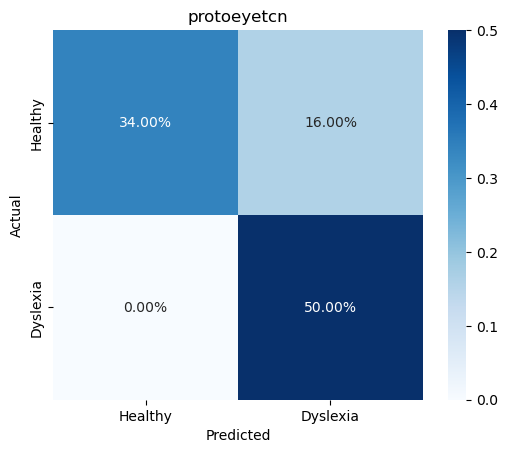

In [13]:
# Plot confusion matrix
class_labels = [0, 1]
class_names = ["Healthy", "Dyslexia"]

y_true = targets.detach().cpu().numpy().astype(int)
y_pred = predictions.detach().cpu().numpy().astype(int)
sklearn_labels = [class_names[target] for target in y_true]

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)

clear_output(wait=True)

ax = sns.heatmap(confusion_matrix/np.sum(confusion_matrix), xticklabels=['Healthy', 'Dyslexia'], yticklabels=['Healthy', 'Dyslexia'], annot=True, fmt='.2%', square=True, cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title(model_architecture)
plt.savefig(checkpoint_path + evaluation_split + "_set_confusion_matrix.png", dpi=600)

In [14]:
if model_params.criterion == 'BCE_with_logits':
    y_score = probabilities.detach().cpu().numpy()
elif model_params.criterion == 'CE':
    y_score = probabilities.detach().cpu().numpy()[:,1]

acc = sklearn.metrics.accuracy_score(y_true, y_pred)
brier = sklearn.metrics.brier_score_loss(y_true, y_score)
auc = sklearn.metrics.roc_auc_score(y_true, y_score)
balanced_acc = sklearn.metrics.balanced_accuracy_score(y_true, y_pred)
f1 = sklearn.metrics.f1_score(y_true, y_pred)
precision = sklearn.metrics.precision_score(y_true, y_pred)
recall = sklearn.metrics.recall_score(y_true, y_pred)

name = model_architecture

text_file = open(checkpoint_path + evaluation_split + "_Result.txt", "w")
text_file.write(f'{name} classifier accuracy: {acc}\n')
text_file.write(f'{name} classifier brier score: {brier}\n')
text_file.write(f'{name} classifier auc score: {auc}\n')
text_file.write(f'{name} classifier balanced accuracy: {balanced_acc}\n')
text_file.write(f'{name} classifier f1 score: {f1}\n')
text_file.write(f'{name} classifier precision: {precision}\n')
text_file.write(f'{name} classifier recall: {recall}\n')
text_file.write('\n')
text_file.close()

print(f'{name} classifier accuracy: {acc}')
print(f'{name} classifier brier score: {brier}')
print(f'{name} classifier auc score: {auc}')
print(f'{name} classifier balanced accuracy: {balanced_acc}')
print(f'{name} classifier f1 score: {f1}')
print(f'{name} classifier precision: {precision}')
print(f'{name} classifier recall: {recall}')

protoeyetcn classifier accuracy: 0.84
protoeyetcn classifier brier score: 0.12307392669967591
protoeyetcn classifier auc score: 0.984
protoeyetcn classifier balanced accuracy: 0.8400000000000001
protoeyetcn classifier f1 score: 0.8620689655172413
protoeyetcn classifier precision: 0.7575757575757576
protoeyetcn classifier recall: 1.0
